Import needed libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.datasets import mnist
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

A class for network object, data load, and preprocessing, train, test, evaluation and mode creation and summary

In [2]:
class Network:

    def __init__(self) -> None:
        pass

    # load the dataset (MNIST)
    def load_dataset(self):
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        # convert grayscale images to channels
        self.x_train = np.stack((self.x_train,)*3, axis=-1)
        self.x_test  = np.stack((self.x_test,)*3, axis=-1)

        # resize images to 48x48 beacuse of VGG network's input's min size
        self.x_train = tf.image.resize(self.x_train, (48, 48)).numpy()
        self.x_test  = tf.image.resize(self.x_test, (48, 48)).numpy()
        self.x_train = self.x_train.astype('float32') / 255.0
        self.x_test  = self.x_test.astype('float32') / 255.0

        # one-hor encoding of labels
        self.y_train = to_categorical(self.y_train, 10)
        self.y_test  = to_categorical(self.y_test, 10)

        # split training data with size 0.2 for cross validation
        self.x_train2, self.x_val, self.y_train2, self.y_val = train_test_split(self.x_train, self.y_train, test_size=0.2, random_state=42)
    def load_dataset():
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x_train = np.stack((x_train,)*3, axis=-1)
        x_test  = np.stack((x_test,)*3, axis=-1)
        x_train = x_train.astype('float32') / 255.0
        x_test  = x_test.astype('float32') / 255.0

        # one-hor encoding of labels
        self.y_train = to_categorical(self.y_train, 10)
        self.y_test  = to_categorical(self.y_test, 10)

        # split training data with size 0.2 for cross validation
        self.x_train2, self.x_val, self.y_train2, self.y_val = train_test_split(self.x_train, self.y_train, test_size=0.2, random_state=42)



    # show one instance of each class
    def show_instances(self):
        # select one instance of each class
        class_instances = []
        for i in range(10):
            class_instance = None
            for j, label in enumerate(self.y_train.argmax(axis=1)):
                if label == i:
                    class_instance = self.x_train[j]
                    break
            class_instances.append(class_instance)

        # show selected instances
        plt.figure(figsize=(12, 6))
        for i, img in enumerate(class_instances):
            plt.subplot(2, 5, i+1)
            plt.imshow(img.astype('float32').squeeze(), cmap='gray')
            plt.title(f'Class: {i}')
            plt.axis('off')
        plt.show()


    # create model with given parameters
    def create_model(self, dropout_rate=0.5):
        model = Sequential()
        # load the VGG16 model
        try:
            # load vgg weights from imagenet (pre trained)
            vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
        except Exception as e:
            # download VGG16 weights manually
            vgg16_base = VGG16(weights=None, include_top=False, input_shape=(48, 48, 3))
            vgg16_base.load_weights(tf.keras.utils.get_file(
                'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                cache_subdir='models'))

        # Freeze the  VGG16 weights
        for layer in vgg16_base.layers:
            layer.trainable = False

        # fully connected classifier
        model.add(vgg16_base)
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(10, activation='softmax'))

        # compile and report the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.model = model
        self.model.summary()


    # train the model on the training set and report train, validation and test results
    def train_eval(self, dropout=0.5):
        self.create_model(dropout_rate=dropout)
        history = self.model.fit(self.x_train, self.y_train, validation_split=0.2, epochs=10, batch_size=200, verbose=1)

        # evaluate the model on the training, validation, and test data
        train_loss, train_accuracy = self.model.evaluate(self.x_train, self.y_train, verbose=0)
        val_loss, val_accuracy     = self.model.evaluate(self.x_val, self.y_val, verbose=0)
        test_loss, test_accuracy   = self.model.evaluate(self.x_test, self.y_test, verbose=0)

        print(f'Train accuracy: {train_accuracy}')
        print(f'Validation accuracy: {val_accuracy}')
        print(f'Test accuracy: {test_accuracy}')

        # plot the results of train and evalution loss
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        # plot the results of train and evalution accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy over epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        # displaying the results in a table
        results = {
            'Dataset': ['Train', 'Validation', 'Test'],
            'Loss': [train_loss, val_loss, test_loss],
            'Accuracy': [train_accuracy, val_accuracy, test_accuracy]
        }

        results_df = pd.DataFrame(results)
        print(results_df)




### main program

load the dataset and show one instance of each class

11490434/11490434 [==============================] - 2s 0us/step


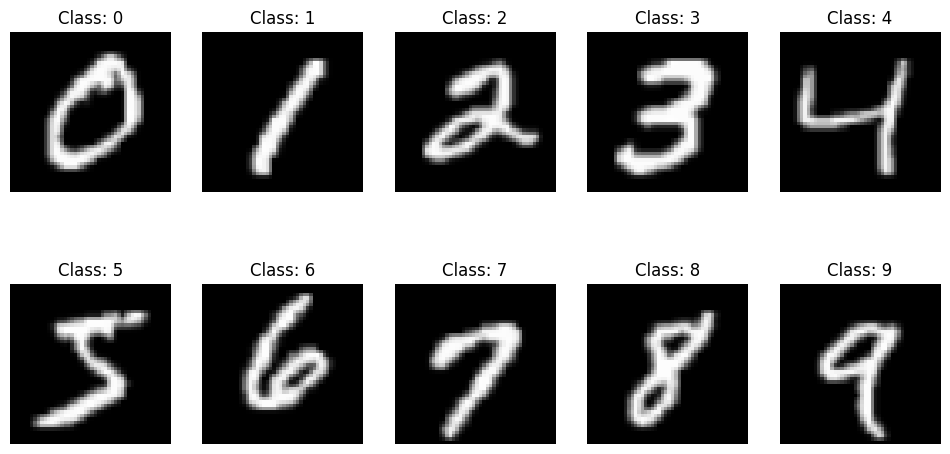

In [3]:
net = Network()
net.load_dataset()
net.show_instances()

train the model with pretrained weights on data and report the results

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                         

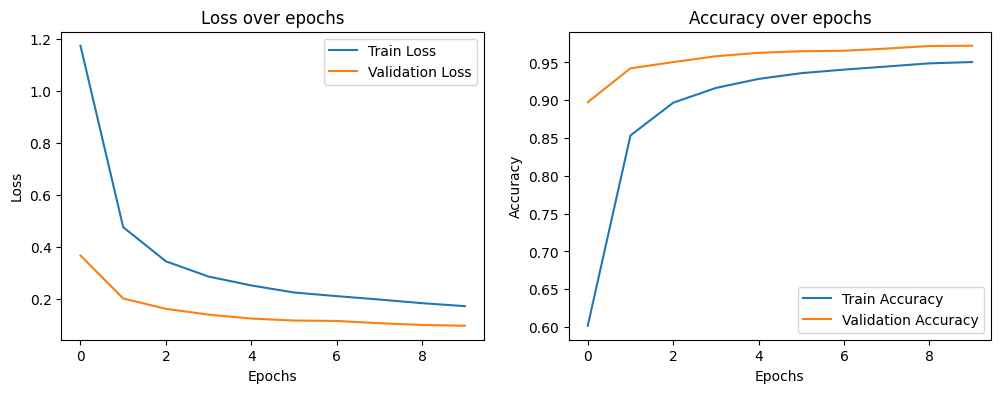

      Dataset      Loss  Accuracy
0       Train  0.083508  0.974433
1  Validation  0.085624  0.974083
2        Test  0.098653  0.970200


In [4]:
net.train_eval()

### Q3

### VGG16's Architecture

1. Input Layer:
The input to VGG16 is a fixed-size 224x224 RGB image. Preprocessing involves subtracting the mean RGB value from each pixel.
2. Convolutional Layers:
The network has 13 convolutional layers.
All convolutional layers use small 3x3 filters, which helps capture fine details and makes the network deeper.
The convolution stride is fixed to 1 pixel; padding is "same" meaning the input dimensions are preserved after convolution.
Each convolutional layer is followed by a ReLU activation function to introduce non-linearity.
3. Pooling Layers:
There are 5 max-pooling layers, each with a 2x2 filter and a stride of 2.
4. Fully Connected Layers:
The network includes 3 fully connected layers:
The first two FC layers have 4096 neurons each.
The final FC layer has 1000 neurons.
5. Output Layer:
The last FC layer is followed by a softmax activation function that outputs probabilities for the 1000 classes.


Total Layers: 16 weight layers (13 Convolutional + 3 Fully Connected)


Activation Function: ReLU after each convolutional and fully connected layer


Pooling: Max Pooling 


Output: Softmax activation in the final layer

### Comparing results of Q1 and Q2

Accuracy:

Simple CNN: Achieves high accuracy (~99%) on MNIST due to the simplicity of the dataset.

VGG16 Pretrained: Achieve a little worse results because of overkill for MNIST.

Reasons behind different results:


Training Time:

Simple CNN: Faster training time due to fewer layers and parameters.

VGG16 Pretrained: Slower training time due to the depth of the network and a large number of parameters.


Computational Resources:

Simple CNN: Requires less computational power and memory.

VGG16 Pretrained: Requires significantly more computational power and memory.


Overfitting:

Simple CNN: Less overfitting due to fewer parameters.

VGG16 Pretrained: More prone to overfitting on small datasets like MNIST due to the large number of parameters.


Flexibility and Transfer Learning:

Simple CNN: Limited to the specific task and dataset.

VGG16 Pretrained: Can be fine-tuned for other image classification tasks, benefiting from pretrained weights on ImageNet.


For MNIST, a simple CNN is often more efficient in terms of training time and computational resources.
VGG16 is overkill for MNIST but advantageous for more complex datasets due to its depth and the power of transfer learning.
While both architectures can achieve high accuracy on MNIST, the simple CNN is more efficient and practical. VGG16, is more powerful, and better suited for more complex datasets where its depth and pretrained weights can be fully utilized.

### Transfer Learning

Transfer learning is a machine learning technique where a model developed for a particular task is reused as the starting point for a model on a second task. This approach is especially useful when the second task has limited labeled data but is related to the first task for which the model was trained. Transfer learning is using the knowledge gained from the first task to improve learning in the second task.

Reasons Behind Transfer Learning:


Limited Data: To avoid overfitting and to achieve good performance. 

Training Time: Training deep neural networks from scratch is computationally expensive and time-consuming. Transfer learning allows you to start with a pretrained model, significantly reducing the training time because the model has already learned useful features from a large dataset.


Performance Improvement: Fine-tuning these models on the target task usually results in better performance compared to training from scratch.

Efficiency: Transfer learning provides a practical approach to achieve high performance without the need for extensive data collection.